# Cross-batch validation

To test the model’s generalization ability to new batches, we conduct a cross-batch validation under a CHIR duration of 24h. In each round of the cross-batch validation, the model is trained on three batches and tested on the remaining one. On the test batch, We compare the predicted "Deviation Score" with the true "ΔCHIR concentration" for each CHIR concentration level (**Supplementary Fig. S10g**).

In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline

In [2]:
# load the dataset
df = pd.read_pickle("./data/dataset.pkl")

In [3]:
batches = np.sort(df.batch_name.unique())

result = [] # the predicted Deviation Scores
delta_concs = [] # the true ΔCHIR concentration

feature_selectors = []

# iterate over each batch's testing turn
for batch_name in batches:
    
    train_data = df[df.batch_name != batch_name]
    test_data = df[df.batch_name == batch_name]
    
    # define the machine learning classifier object

    lr = LogisticRegression(penalty = "elasticnet", l1_ratio = 0.1, 
                            solver = "saga", class_weight="balanced",
                             C = 20, max_iter=20000, random_state=12345) 
    feature_selector = SelectKBest(f_classif, k = 4)
    clf = Pipeline([('scaler', StandardScaler()), 
                    ("feature selection", feature_selector),
                    ('classifier', lr)])

    clf.fit(train_data.feature.to_list(), train_data.label_24.to_list())
    feature_selectors.append(feature_selector)
    
    score = {}
    delta_conc = {}
    for conc in np.sort(test_data.CHIR_conc.unique()):
        pred_label = clf.predict(test_data[test_data.CHIR_conc == conc].feature.to_list())
        score["%2d μM" % conc] = (pred_label == "high").mean() - (pred_label == "low").mean()
        delta_conc["%2d μM" % conc] = test_data.loc[test_data.CHIR_conc == conc, 
                                                   "delta_CHIR_conc_24"].iloc[0]
    
    result.append(score)
    delta_concs.append(delta_conc)

# save the predicted Deviation Scores and the True ΔCHIR concentrations to a pandas DataFrame
result = pd.DataFrame(result, 
                      index = batches
                     )
result = result[sorted(result.columns)]

delta_concs = pd.DataFrame(delta_concs, 
                      index = batches
                     )
delta_concs = delta_concs[sorted(delta_concs.columns)]

In [4]:
# The predicted Deviation Scores on each batch
result

,2 μM,4 μM,6 μM,8 μM,10 μM,12 μM
CD01-1,NaN,-0.583333,-0.166667,-0.125000,0.166667,NaN
CD01-2,NaN,0.000000,-0.083333,-0.041667,0.000000,NaN
CD01-3,-0.8125,-0.375000,0.000000,0.250000,0.437500,0.5625
CD01-4,0.0000,0.000000,0.000000,0.000000,0.000000,0.0000


In [5]:
# The true ΔCHIR concentrations on each batch
delta_concs

,2 μM,4 μM,6 μM,8 μM,10 μM,12 μM
CD01-1,NaN,-2,0,0,2,NaN
CD01-2,NaN,0,0,0,0,NaN
CD01-3,-4.0,-2,0,0,0,2.0
CD01-4,-2.0,0,0,0,0,0.0


We further compute the Pearson's *r* between the predicted Deviation Scores and the true ΔCHIR concentrations and show the correlation plot (**Fig. 4g**).

In [6]:
import numpy as np
from scipy import stats

### Compute Pearson's r with the Pvalue.

X = delta_concs.to_numpy().ravel()
X = X[np.logical_not(np.isnan(X))]

Y = result.to_numpy().ravel()
Y = Y[np.logical_not(np.isnan(Y))]

r, p = stats.pearsonr(X, Y)
print("Pearson's r = ", r)
print("p = ", p)

# Assume linear dependence: Y = kX + b. Estimate k and b (for plotting the trend line)
k, b = np.polyfit(X, Y, 1)

Pearson's r =  0.8237556095777329
p =  8.061667917742772e-06


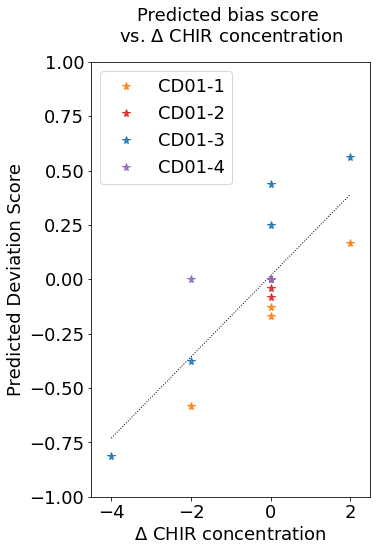

In [7]:
from matplotlib import pyplot as plt

### Obtain the correlation plot.

plt.figure(figsize = (5, 8))

# Plot the dotted trend line Y = kX + b.
plt.plot([-4, 2], [-4 * k + b, 2 * k + b], color = "black", linewidth =1, linestyle = ":")

# plot the points for each batch

colors = {"CD01-1":"C1",
          "CD01-2":"C3",
          "CD01-3":"C0",
          "CD01-4":"C4"
         }

for batch_name in batches:
    X = delta_concs.loc[batch_name]
    X = X[X.notna()]
    Y = result.loc[batch_name]
    Y = Y[Y.notna()]
    plt.plot(X, Y, ms = 8, color = colors[batch_name], 
             linewidth = 0, marker = "*", 
             label = batch_name, alpha = 0.9)

plt.xticks([-4, -2, 0, 2], fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylim([-1, 1])
plt.xlim([-4.5, 2.5])
plt.title("Predicted bias score \nvs. $\Delta$ CHIR concentration",fontsize = 18, pad = 20)
plt.xlabel("$\Delta$ CHIR concentration", fontsize = 18)
plt.ylabel("Predicted Deviation Score", fontsize = 18)
plt.legend(loc = "upper left", fontsize = 18)
plt.show()

Note that during cross-batch validation, feature selection is performed on each round's training set. We can also show the features selected at each round (**Supplementary Fig. S10h**).

In [8]:
with open("./data/feature_name.txt") as f:
    feature_name_list = f.readlines()
feature_name_list = list(filter(lambda st: st != "", feature_name_list))
for i in range(len(feature_name_list)):
    feature_name_list[i] = feature_name_list[i].strip("\n")
feature_name_list = np.array(feature_name_list)

for i in range(4):
    
    print("Round %d:" % (i+1))
    print(list(feature_name_list[feature_selectors[i].get_support().nonzero()]))

Round 1:
['Circumference (pre-phase)', 'Optical Flow (pre-phase)', 'Optical Flow (mid-phase)', 'Optical Flow (post-phase)']
Round 2:
['Circumference (post-phase)', 'Optical Flow (pre-phase)', 'Optical Flow (mid-phase)', 'Optical Flow (post-phase)']
Round 3:
['Cell Brightness (post-phase)', 'Circumference (mid-phase)', 'Circumference (post-phase)', 'Optical Flow (pre-phase)']
Round 4:
['Cell Brightness (post-phase)', 'Circumference (post-phase)', 'Optical Flow (pre-phase)', 'Optical Flow (post-phase)']
